In [2]:
import os
import glob
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from PIL import Image
from sklearn.preprocessing import RobustScaler #importando o Robust Scaler

In [3]:
load_dotenv('test.env')
raw_dir = os.environ['RAW_DIR']
interim_dir = os.environ['INTERIM_DIR']

In [ ]:
raw_dir, interim_dir

In [5]:
def medianmad_norm(arr_like):
    '''
    Normalize by median and MAD

    Modified version from the function made available by the professor
    '''
    np_arr = np.array(arr_like)
    median = np.median(np_arr)
    dev = np.abs(np_arr - median)
    mad = np.median(dev)
    norm = ((np_arr - median) / mad)
    return (norm,mad)

def tanh_modified_norm(arr_like):
    np_arr = np.array(arr_like)

    mean = np.mean(np_arr)
    std = np.std(np_arr)

    return 0.5*(np.tanh(0.01*((np_arr-mean)/std))+1)

In [6]:
original_arr = np.random.randint(0, 100, 10)
norm_arr, mad = medianmad_norm(original_arr)
print(original_arr, norm_arr, mad)

[16 84 71 77  5 74 33 67 82 15] [-3.78571429  1.07142857  0.14285714  0.57142857 -4.57142857  0.35714286
 -2.57142857 -0.14285714  0.92857143 -3.85714286] 14.0


In [7]:
test_path = os.path.join(raw_dir,'AVC/001_FLAIR01.bmp')
test_img  = cv.imread(test_path, cv.IMREAD_GRAYSCALE)
test_img.shape, test_img.dtype, test_img.max(), test_img.min()

((448, 448), dtype('uint8'), 254, 0)

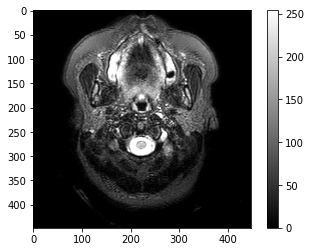

In [8]:
plt.imshow(test_img, cmap='gray')
plt.colorbar()

<BarContainer object of 20 artists>

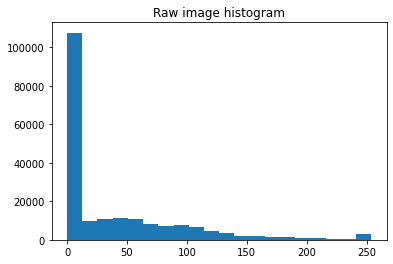

In [9]:
nbins=20
h, bin_edges = np.histogram(test_img, nbins)
w=test_img.max()/nbins
bin_centers = bin_edges[1:]-(w/2)
plt.title("Raw image histogram")
plt.bar(bin_centers, h, width=w)
# sns.distplot(test_img)


In [10]:
norm_img, mad = medianmad_norm(test_img)
norm_img.shape, norm_img.dtype, norm_img.max(), norm_img.min(), mad

((448, 448), dtype('float64'), 49.8, -1.0, 5.0)

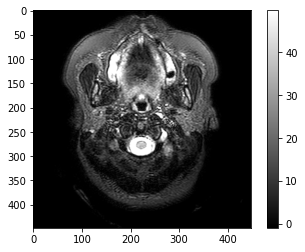

In [11]:
plt.imshow(norm_img, cmap='gray')
plt.colorbar()

<BarContainer object of 20 artists>

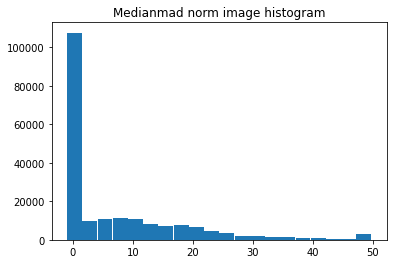

In [12]:
nbins=20
h, bin_edges = np.histogram(norm_img, nbins)
w=norm_img.max()/nbins
bin_centers = bin_edges[1:]-(w/2)
plt.title("Medianmad norm image histogram")
plt.bar(bin_centers, h, width=w)
# sns.distplot(norm_img)

In [13]:
norm_img = tanh_modified_norm(test_img)
norm_img.shape, norm_img.dtype, norm_img.max(), norm_img.min()

((448, 448), dtype('float64'), 0.519341138516456, 0.4965199527632426)

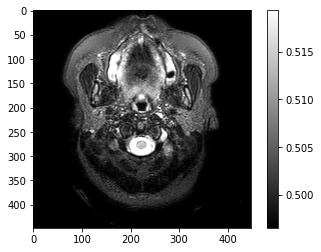

In [14]:
plt.imshow(norm_img, cmap='gray')
plt.colorbar()

<BarContainer object of 20 artists>

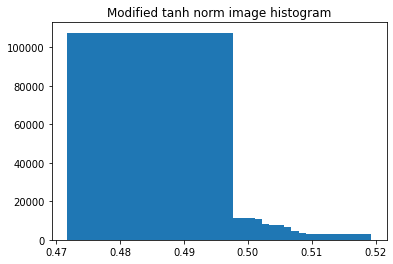

In [15]:
nbins=20
h, bin_edges = np.histogram(norm_img, nbins)
w=norm_img.max()/nbins
bin_centers = bin_edges[1:]-(w/2)
plt.title("Modified tanh norm image histogram")
plt.bar(bin_centers, h, width=w)
# sns.distplot(norm_img)

In [16]:
with open("../data/interim/filenames.txt") as f:
    filenames = f.readlines()

img_list = [os.path.join(raw_dir, img_path[:-1]) for img_path in filenames]

In [17]:
def get_mask_path(img_path, mask_suffix='_mask.png'):
    img_wo_ext = os.path.splitext(img_path)[0]
    mask_path = img_wo_ext + mask_suffix
    return mask_path

In [18]:
def save_histogram(arr_like, output_path, title='', nbins=20):
    h, bin_edges = np.histogram(arr_like, nbins)
    w = np.max(arr_like)/nbins
    bin_centers = bin_edges[1:]-(w/2)
    plt.figure(dpi=100, frameon=False)
    if len(title) > 0:
        plt.title(title)
    plt.bar(bin_centers, h, width=w)
    plt.savefig(output_path)
    plt.close()

In [19]:
def crop_zero_borders(img_arr):
    coords = np.argwhere(img_arr > 0)

    y_min, x_min = np.min(coords, axis=0)
    y_max, x_max = np.max(coords, axis=0) + 1

    return img_arr[y_min:y_max, x_min:x_max], (y_min, y_max, x_min, x_max)

In [20]:
for img_path in img_list:
    img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
    if img is None:
        continue

    mask_path = get_mask_path(img_path)
    if not os.path.exists(mask_path):
        continue

    mask = cv.imread(mask_path, cv.IMREAD_UNCHANGED)
    if mask is None:
        continue

    cropped, (y_min, y_max, x_min, x_max) = crop_zero_borders(img)

    
    scaler = RobustScaler() 
    normed = scaler.fit_transform(cropped)

    masked = normed * (mask == mask.max())[y_min:y_max, x_min:x_max]
    print('masked max min', masked.max(), masked.min())

    # out_path = os.path.join(interim_dir, img_path.split(raw_dir)[1])
    out_path = os.path.join(interim_dir, "hists", os.path.splitext(img_path.split(raw_dir)[1])[0] + ".png")
    
    # ok = cv.imwrite(out_path, masked)
    # print("write", img_path, out_path, ok)

    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    save_histogram(masked[masked > 0], out_path, "Modified norm lesion histogram", nbins=50)

masked max min 1.8274111675126903 -0.34
masked max min 2.011267605633803 -2.1421800947867298
masked max min 1.2764227642276422 -0.38823529411764707
masked max min 1.011111111111111 0.0
masked max min 1.434782608695652 -0.028169014084507043
masked max min 1.244186046511628 0.0
masked max min 1.1888888888888889 0.0
masked max min 1.3778625954198473 0.0
masked max min 1.8679245283018868 -1.3366336633663367
masked max min 1.6521739130434783 -1.5714285714285714
masked max min 2.0 -2.091666666666667
masked max min 2.214689265536723 -2.321243523316062
masked max min 2.8115942028985508 -1.2087912087912087
masked max min 1.9387755102040816 -1.0707070707070707
masked max min 1.5299145299145298 -0.8163265306122449
masked max min 1.5614035087719298 -0.8461538461538461
masked max min 1.9574468085106382 -0.5914396887159533
masked max min 2.700361010830325 -0.6379746835443038
masked max min 2.7384615384615385 -0.12307692307692308
masked max min 1.0453333333333332 0.0
masked max min 1.2876712328767124

In [23]:
coords = np.argwhere(img > 0)

y_min, x_min = np.min(coords, axis=0)
y_max, x_max = np.max(coords, axis=0) + 1

coords, img[y_min, x_min], img[y_max, x_max]


(array([[ 27, 184],
        [ 27, 185],
        [ 27, 186],
        ...,
        [434, 206],
        [440, 211],
        [440, 212]]),
 0,
 0)

In [24]:
img

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [25]:
img[6,361]

0

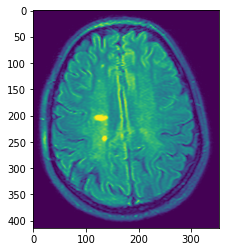

In [26]:
plt.imshow(cropped)

In [29]:
img.shape, cropped.shape

((448, 448), (414, 354))

In [30]:
with Image.open(os.path.join(raw_dir, 'AVC/051_FLAIR12_mask.png')) as f:
    test_mask = np.array(f)

test_mask.shape, test_mask.max(), test_mask.min(), test_mask.dtype

((512, 512), 254, 253, dtype('int32'))

In [31]:
test_mask = cv.imread(os.path.join(raw_dir, 'AVC/051_FLAIR12_mask.png'), cv.IMREAD_UNCHANGED)
test_mask = test_mask == test_mask.max()
test_mask.shape, test_mask.max(), test_mask.min(), test_mask.dtype

((512, 512), True, False, dtype('bool'))

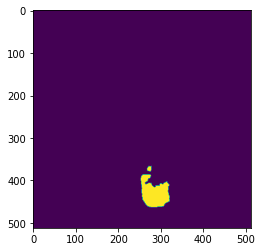

In [32]:
plt.imshow(test_mask)